In [1600]:
import sys
sys.path.append("../")

from PIL import Image

import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

from relic.encoders import resnet18, resnet50
from relic.aug import get_inference_transforms, get_global_transforms

from PIL import Image
import matplotlib.pyplot as plt
from numpy.linalg import norm
import numpy as np
import random

In [1601]:
# SEED = 42

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)

In [1602]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1603]:
# def get_inference_transforms(image_size=(96, 96)):
#     return transforms.Compose([
#         transforms.Resize(image_size),
#         transforms.Lambda(_grayscale_to_rgb),
#         transforms.ToTensor()
#     ])
def _round_up_to_odd(num):
    return np.ceil(num) // 2 * 2 + 1
    
def get_global_transforms(image_size):
    color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2)
    rotation = transforms.RandomRotation(degrees=(-20, 20))
    return transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.15, p=0.8),
        transforms.RandomApply([rotation], p = 0.8),
        transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0)),
        transforms.RandomApply([color_jitter], p=0.8),
        transforms.GaussianBlur(_round_up_to_odd(int(image_size * 0.01))),
        transforms.ToTensor()
    ])

def get_local_transforms(image_size):
    color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2)
    rotation = transforms.RandomRotation(degrees=(-20, 20))
    return transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.15, p=0.8),
        transforms.RandomApply([rotation], p = 0.8),
        transforms.RandomResizedCrop(int(image_size*3/7), scale=(0.5, 1.0)),
        transforms.RandomApply([color_jitter], p=0.8),
        transforms.GaussianBlur(_round_up_to_odd(int(image_size * 0.01))),
        transforms.ToTensor()
    ])

In [1604]:
IMAGE_SIZE = 256

transform = get_inference_transforms(image_size=(IMAGE_SIZE, IMAGE_SIZE))
training_transform = get_global_transforms(image_size=IMAGE_SIZE)
local_transform = get_local_transforms(image_size = IMAGE_SIZE)

first_image_path = "/home/sacha/mtg_card_detection/db_images/839b7b38-cb95-4406-af50-4d97884e2489.jpg"

second_image_path = "/home/sacha/mtg_card_detection/s-l400.png"

third_image_path = "/home/sacha/mtg_card_detection/db_images/2edd7be9-9334-4684-b642-1aaf2000e054.jpg"

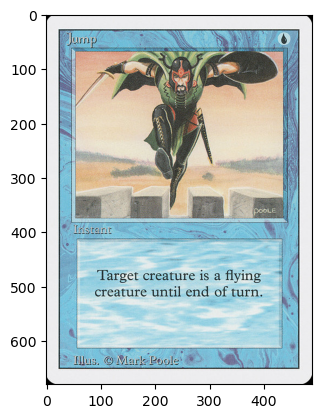

/tmp/ipykernel_4347/3677713634.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.imshow(np.moveaxis(np.array(training_transform(first_image)), 0, -1))


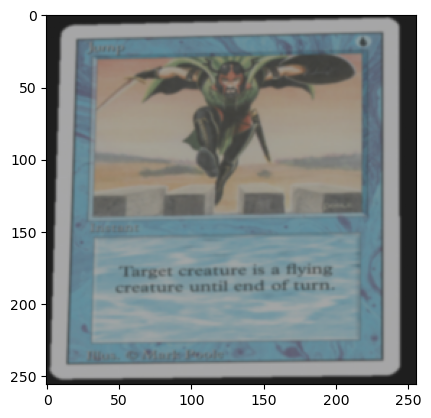

/tmp/ipykernel_4347/3677713634.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.imshow(np.moveaxis(np.array(local_transform(first_image)), 0, -1))


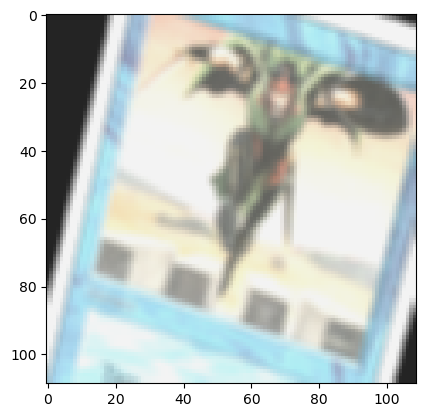

In [1605]:
first_image = Image.open(first_image_path)
first_image = first_image.convert('RGB')
second_image = Image.open(second_image_path)
third_image = Image.open(third_image_path)

plt.imshow(first_image)
plt.show()

plt.imshow(np.moveaxis(np.array(training_transform(first_image)), 0, -1))
plt.show()

plt.imshow(np.moveaxis(np.array(local_transform(first_image)), 0, -1))
plt.show()

In [1606]:
ckpt = torch.load("/home/sacha/mtg_card_detection/encoder2.pth", map_location='cpu')

# model = resnet50()
model = resnet18()
model.load_state_dict(ckpt)

model = model.eval().to(device)

/tmp/ipykernel_4347/3425210185.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/home/sacha/mtg_card_detection/encoder2.pth", map_location='cpu')


In [1607]:
first_image_features = model(transform(first_image)[torch.newaxis, ...]).cpu().detach().numpy().squeeze()
second_image_features = model(transform(second_image)[torch.newaxis, ...]).cpu().detach().numpy().squeeze()
third_image_features = model(transform(third_image)[torch.newaxis, ...]).cpu().detach().numpy().squeeze()

first_to_second = norm(first_image_features - second_image_features)
first_to_third = norm(first_image_features - third_image_features)
second_to_third = norm(second_image_features - third_image_features)

In [1608]:
print(first_to_second)
print(first_to_third)
print(second_to_third)

6.888869
15.97266
13.112365
